In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL

from utils import  evaluate_model, poly_kernel, gauss_kernel, scoring


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
corner = 3
centers = [[-corner, -corner], [-corner, corner],
           [corner, -corner], [corner, corner]]

X, y = make_blobs(n_samples=N, centers=centers)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[(y==0) | (y==3)] = -1
y[y==2] = 1
data['y'] = y

display(data.head())
data.describe()

,x1,x2,y
0,4.012663,4.306655,-1
1,-2.195879,-3.734394,-1
2,4.426094,3.953268,-1
3,3.943342,4.038095,-1
4,-1.874544,3.524796,1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,0.021490,-0.016786,0.0000
std,3.183448,3.141956,1.0005
min,-6.481190,-5.915109,-1.0000
25%,-3.020416,-2.958619,-1.0000
50%,0.067351,-0.306178,0.0000
75%,3.050460,2.956154,1.0000
max,5.727303,5.403016,1.0000


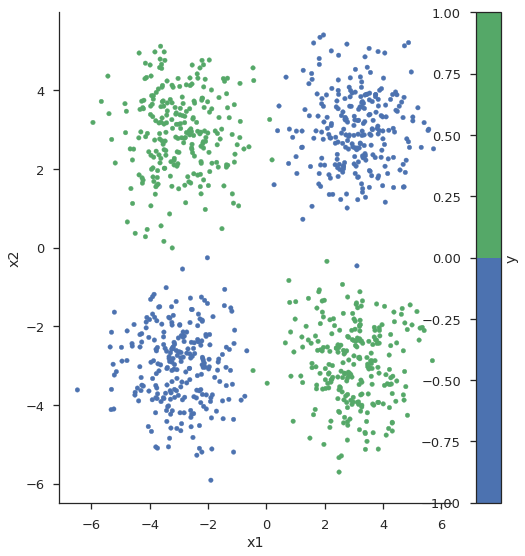

In [3]:
cmap = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
        (0.33333333333333331, 0.6588235294117647, 0.40784313725490196)]
cmap = ListedColormap(cmap)
ax = plt.figure(figsize=(8, 8)).gca()
data.plot.scatter('x1', 'x2', c='y', cmap=cmap, ax=ax)
sns.despine()
plt.tight_layout()

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(39, 39)

# Sparse Model

{'rug': True, 'ax': <matplotlib.axes._subplots.AxesSubplot object at 0x7f916434bf98>, 'rug_kws': {'color': 'r', 'linewidth': 2, 'alpha': 1}}


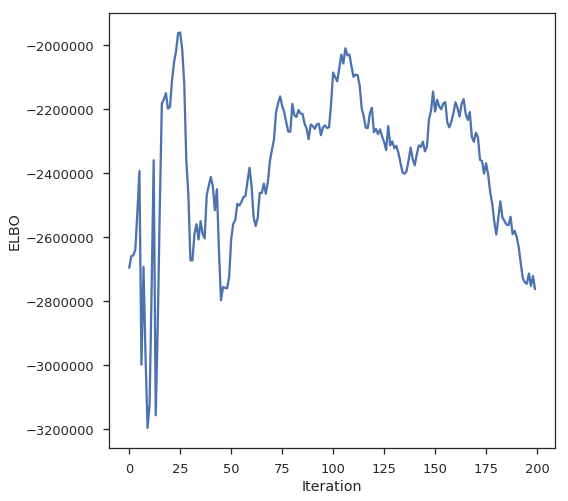

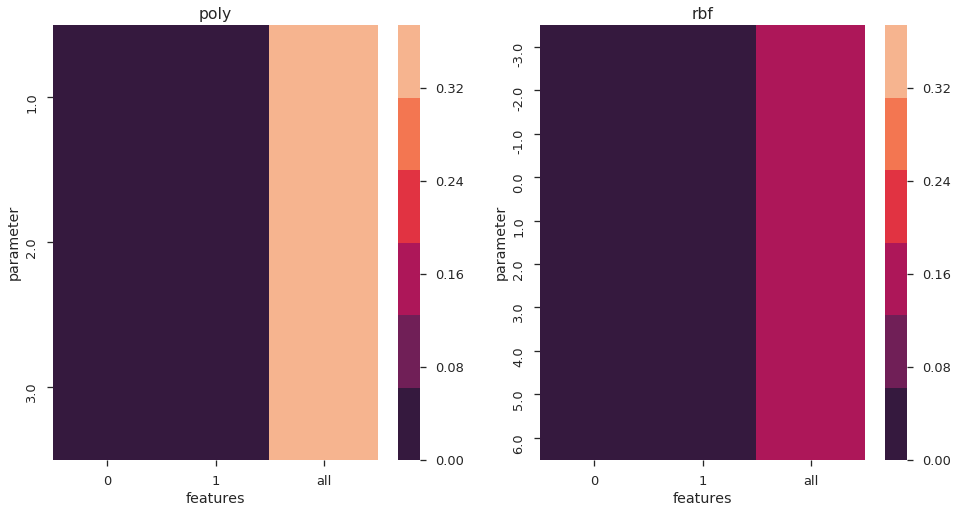

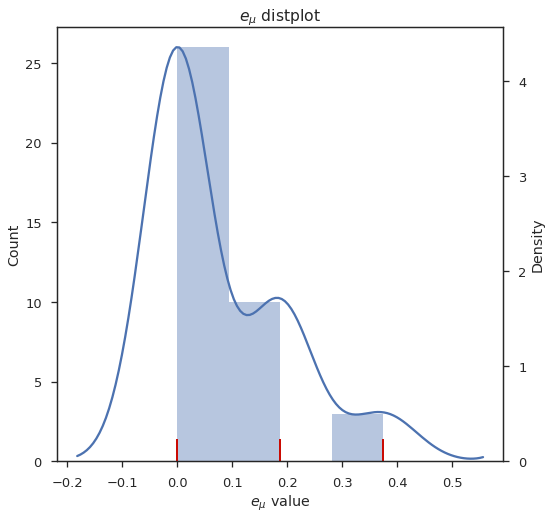

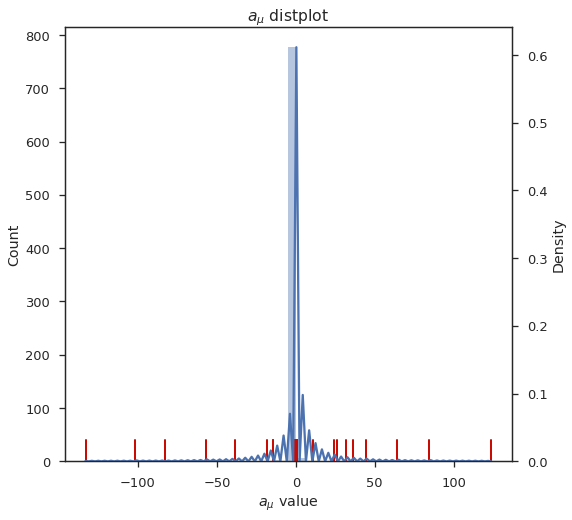

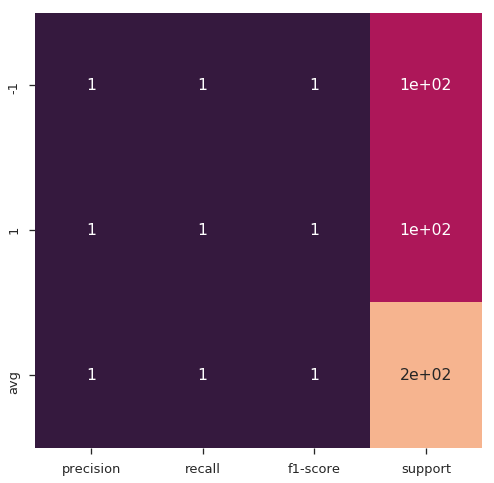

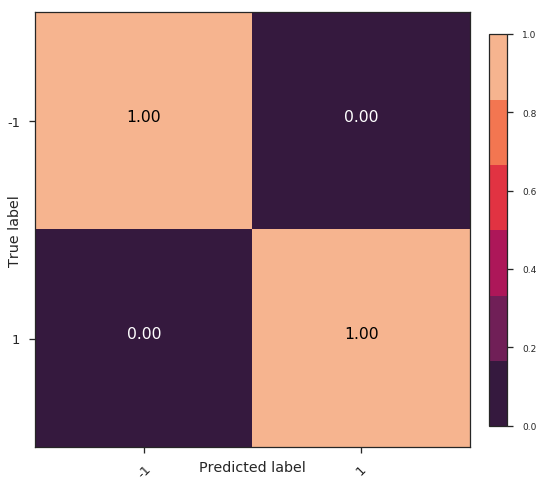

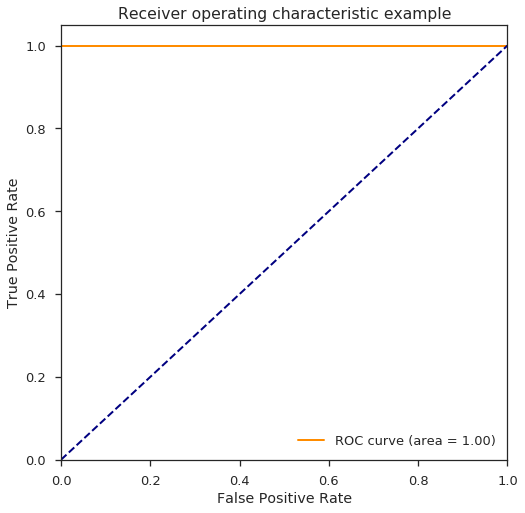

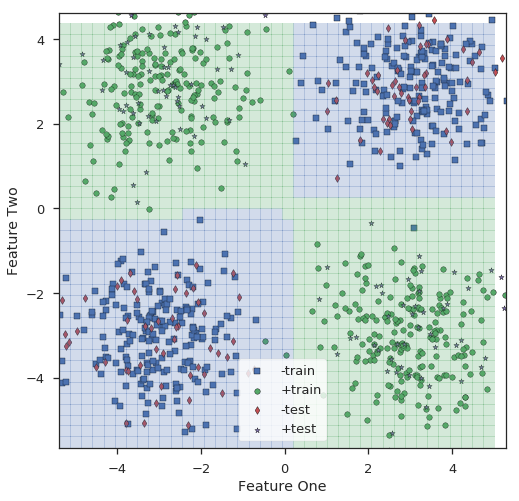

0 - Kernels: 13/39 (0.3333333333333333). SV: 661/666 (0.9924924924924925). Mean e: 0.0768. Median e: 0.0000. Std e: 0.1228. 
1 - Kernels: 13/39 (0.3333333333333333). SV: 661/666 (0.9924924924924925). Mean e: 0.0779. Median e: 0.0000. Std e: 0.1193. 
2 - Kernels: 13/39 (0.3333333333333333). SV: 667/668 (0.9985029940119761). Mean e: 0.0769. Median e: 0.0000. Std e: 0.1330. 
3 - Kernels: 13/39 (0.3333333333333333). SV: 662/666 (0.993993993993994). Mean e: 0.0762. Median e: 0.0000. Std e: 0.1382. 
4 - Kernels: 13/39 (0.3333333333333333). SV: 660/666 (0.990990990990991). Mean e: 0.0789. Median e: 0.0000. Std e: 0.1221. 
5 - Kernels: 13/39 (0.3333333333333333). SV: 664/668 (0.9940119760479041). Mean e: 0.0764. Median e: 0.0000. Std e: 0.1231. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 30.2936,  27.7786,  29.671 ,  29.5127,  30.9498,  12.5754]),
 'score_time': array([ 1.9625,  2.214 ,  2.1069,  2.2237,  2.4184,  1.3974]),
 'test_score': array([ 0.997,  0.997,  0.997,  0.994,  0.997,  0.997]),
 'train_score': array([ 0.997 ,  0.9955,  0.997 ,  0.997 ,  0.997 ,  0.997 ])}

In [5]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1,
                     alpha_gamma=1, beta_gamma=1,
                     alpha_omega=1e-11, beta_omega=1e+9,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False,
                     verbose=False)
evaluate_model(sparse_model, X, y, kernel_attrs)

# Dense Model

{'rug': True, 'ax': <matplotlib.axes._subplots.AxesSubplot object at 0x7f915dea6e10>, 'rug_kws': {'color': 'r', 'linewidth': 2, 'alpha': 1}}


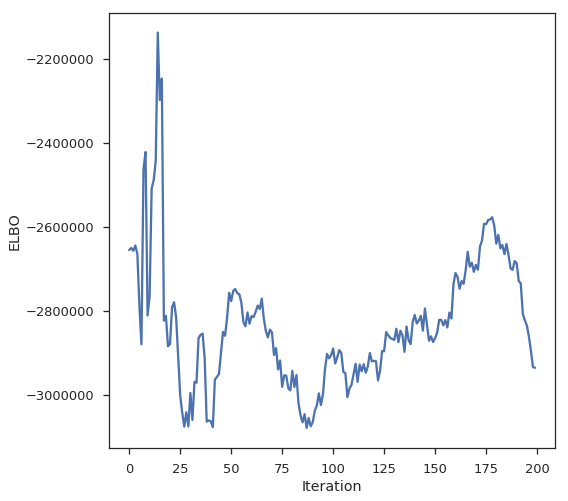

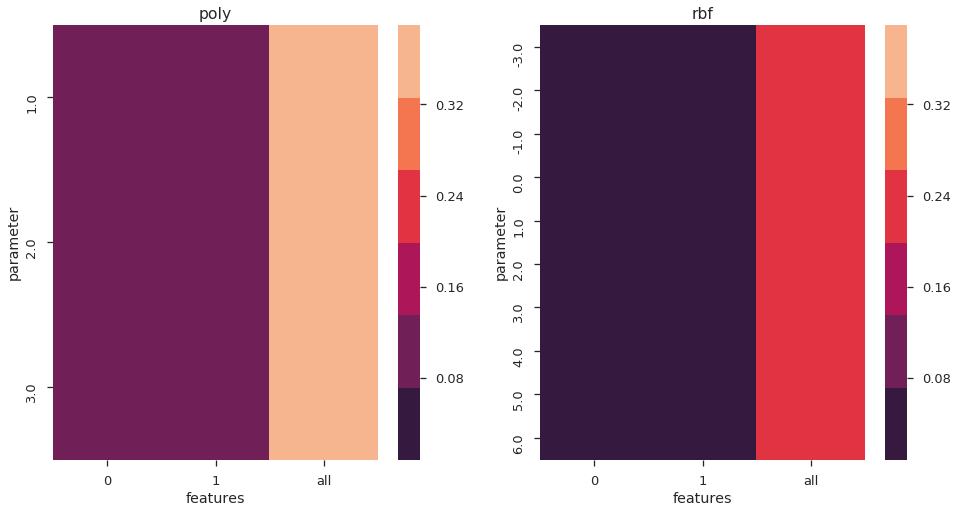

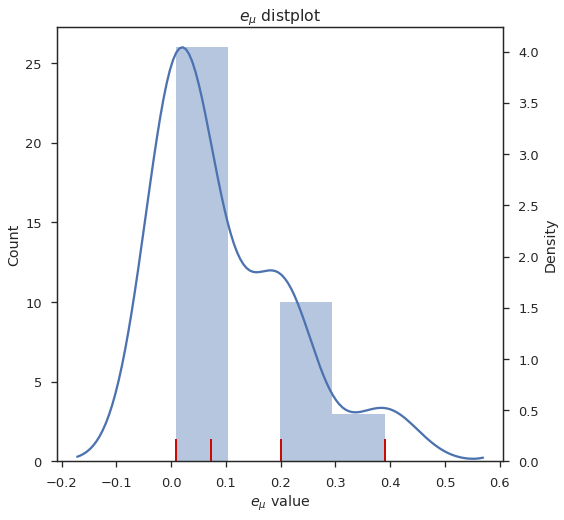

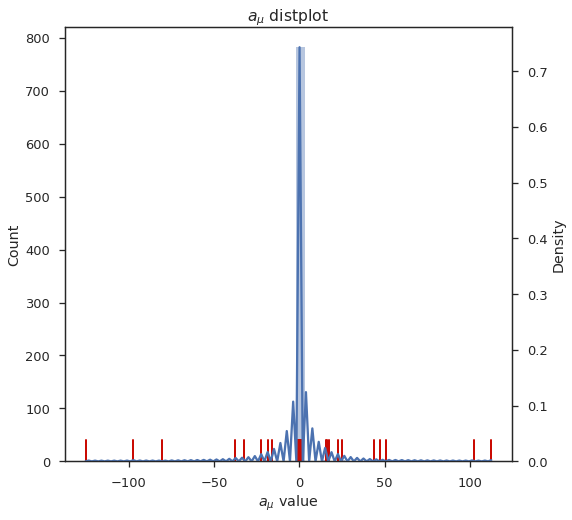

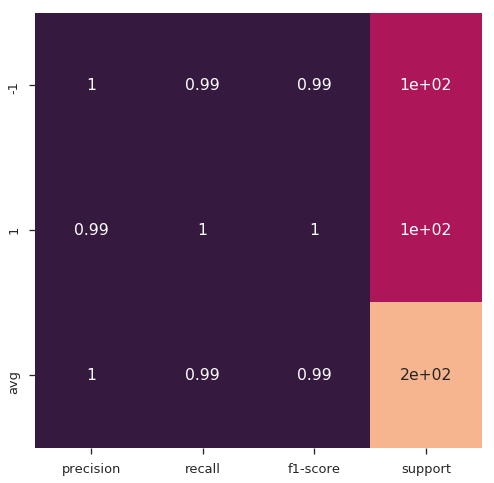

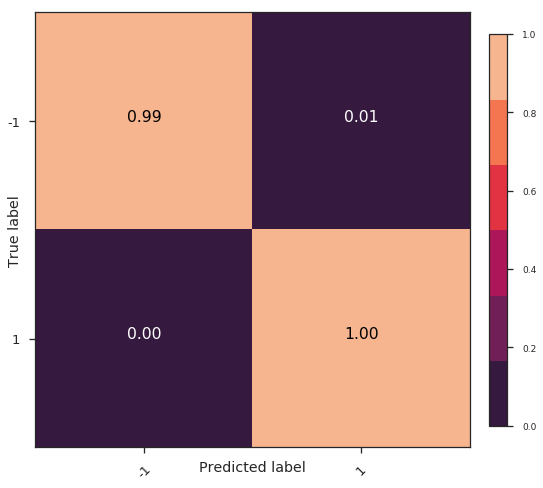

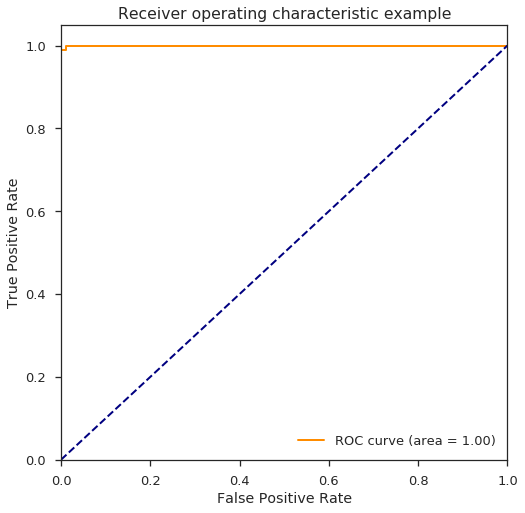

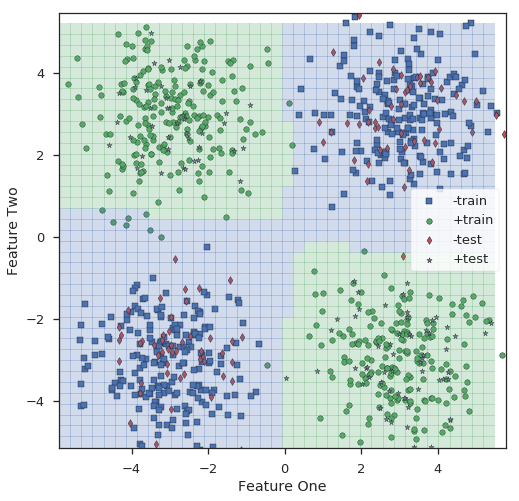

0 - Kernels: 39/39 (1.0). SV: 662/666 (0.993993993993994). Mean e: 0.0636. Median e: 0.0036. Std e: 0.1418. 
1 - Kernels: 39/39 (1.0). SV: 665/666 (0.9984984984984985). Mean e: 0.0937. Median e: 0.0067. Std e: 0.1150. 
2 - Kernels: 39/39 (1.0). SV: 668/668 (1.0). Mean e: 0.0982. Median e: 0.0029. Std e: 0.1120. 
3 - Kernels: 39/39 (1.0). SV: 664/666 (0.996996996996997). Mean e: 0.0670. Median e: -0.0118. Std e: 0.1295. 
4 - Kernels: 19/39 (0.48717948717948717). SV: 659/666 (0.9894894894894894). Mean e: 0.0894. Median e: 0.0000. Std e: 0.1099. 
5 - Kernels: 39/39 (1.0). SV: 663/668 (0.9925149700598802). Mean e: 0.0863. Median e: 0.0079. Std e: 0.1186. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 12.1251,  12.3275,  12.8277,  14.203 ,  13.7422,  14.4949]),
 'score_time': array([ 1.3474,  1.3848,  1.3517,  1.5144,  1.3597,  1.3852]),
 'test_score': array([ 0.994,  0.991,  1.   ,  0.997,  0.997,  0.997]),
 'train_score': array([ 0.9955,  0.9985,  0.9955,  0.9955,  0.997 ,  0.997 ])}

In [6]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False,
                     verbose=False)
evaluate_model(normal_model, X, y, kernel_attrs)

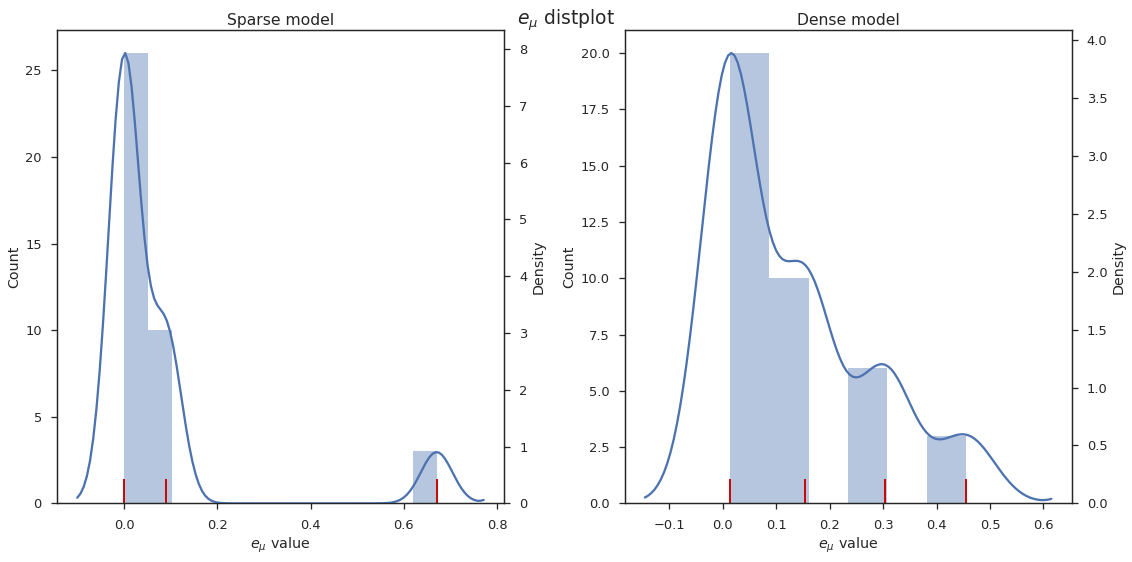

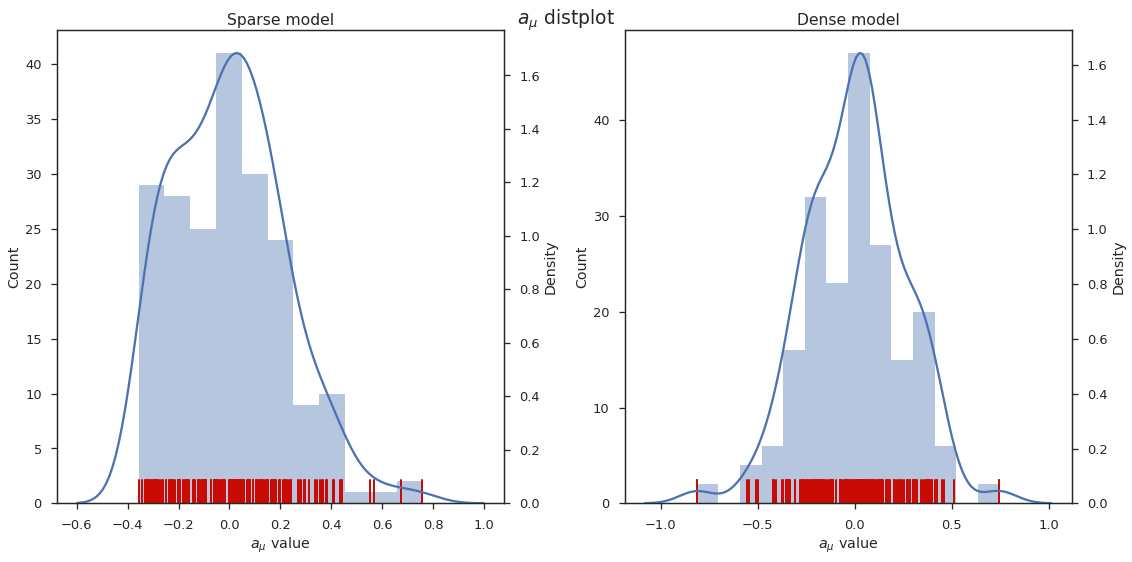

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
sparse_model.plot_e(ax=ax1, rug=True,
                    rug_kws={'color': 'r', 'linewidth': 2,
                             'alpha': 1})
normal_model.plot_e(ax=ax2, rug=True,
                    rug_kws={'color': 'r', 'linewidth': 2,
                             'alpha': 1})
ax1.set_title('Sparse model')
ax2.set_title('Dense model')
fig.suptitle(r'$e_\mu$ distplot')
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
sparse_model.plot_a(ax=ax1, rug=True,
                    rug_kws={'color': 'r', 'linewidth': 2,
                             'alpha': 1})
normal_model.plot_a(ax=ax2, rug=True,
                    rug_kws={'color': 'r', 'linewidth': 2,
                             'alpha': 1})
ax1.set_title('Sparse model')
ax2.set_title('Dense model')
fig.suptitle(r'$a_\mu$ distplot')
plt.tight_layout()